## Covid19 Projection
The purpose of this notebook is to run Covid-19 case projection at Indian State level or at Country level. The outcome is the projection of the total confirmed cases for the target State or Country. 

This solution first tries to understand the approximate time to peak for the target entity (state/country), expected case rates and higher/lower bounds. It determines these parameters from countries that have exhibited similar trends in the past. 

Subsequently, it runs a simulation with the optimized parameters to generate day by day case projections. The simulation assumes 2 waves of infection surges following gaussian distribution and tries to apply that in generating the case projections. It also incorporates various factors such as transmission probability, testing efficiency, intervention impacts, attritions.

### When to use this notebook?

This notebook will run locally. Our simulation and optimization loops are not too heavy computationally. If your local resources are not adequate, we recommend to use the version of the notebook that enables training on Amazon SageMaker, ``covid19_simulator_sagemaker``.

### Install and import libraries

Uncomment to install missing libraries with the correct versions.

In [1]:
#!pip install -r requirements.txt

Import libraries used in the notebook. Additional libraries will be imported as needed in the Python files in the repository.

In [2]:
import sys
sys.path.insert(1, 'src')
import pandas as pd
import numpy as np
import random
import urllib.request
import os
# fixed_seed = 39
# random.seed(fixed_seed)
# np.random.seed(fixed_seed)

import warnings
warnings.filterwarnings("ignore")



The below package contains all the configuration parameters for public datasets as well as disease specific parameters extracted from scientific journals. For details, refer to the references cited in `readme.md` for our codebase.

In [3]:
import config

In [4]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

from simulation_orchestrator import run

### Update local data files from public resources

Prior to running our use cases for various states and countries, we will update our local data with the most up-to-date from public data sources.

In [5]:
# Function to refresh the local data file with the latest version from the web
def download_latest_data (url, local_file):
    with urllib.request.urlopen(url) as response, open(local_file, 'wb') as out_file:
        data = response.read() # a `bytes` object
        out_file.write(data)

# Mapping of online vs offline file locations to refresh
online_offline_data = list()
# Confirmed cases data maintained by Johns Hopkins University
online_offline_data.append((config.confirmed_cases_global_online, 
                            os.path.join(config.base_data_dir, config.confirmed_cases_global_offline)))
# Recovered cases data maintained by Johns Hopkins University
online_offline_data.append((config.recovered_cases_global_online, 
                            os.path.join(config.base_data_dir, config.recovered_cases_global_offline)))
# Deceased cases data maintained by Johns Hopkins University
online_offline_data.append((config.deceased_cases_global_online, 
                            os.path.join(config.base_data_dir, config.deceased_cases_global_offline)))
# Indian states specific cases maintained by COVID19INDIA (www.covid19india.org)
online_offline_data.append((config.india_states_cases_online, 
                            os.path.join(config.base_data_dir, config.india_states_cases_offline)))
# USA population data from census
online_offline_data.append((config.usa_populations_data_online, 
                            os.path.join(config.base_data_dir, config.usa_populations_data_offline)))


# Refresh the local data files with the latest versions from respective web sources
for path_pair in online_offline_data:
    try:
        download_latest_data (path_pair[0], path_pair[1])
        print ('Downloaded latest data from: {}'.format(path_pair[0]))
    except Exception as e:
        print ('Error while downloading {}: {}'.format(path_pair[0], e.__class__))


Downloaded latest data from: https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv
Downloaded latest data from: https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv
Downloaded latest data from: https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv
Downloaded latest data from: https://api.covid19india.org/csv/latest/state_wise_daily.csv
Downloaded latest data from: https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/state/detail/SCPRC-EST2019-18+POP-RES.csv


## Parse data files

Import Python code that will parse through the public data sets and extract historical data relevant for our prediction and simulation environments.

In [6]:
import state_data_loader
import country_data_loader

Run the following cell to load all USA data parsed for each state separately with the recent updates. To use already existing files stored locally, comment out.

In [7]:
# country_code = 'USA'
# state_data_loader.load_us_all(country_code)

## Examples

We will now go through few examples of how we analyze various intervension score for a given state and country. 


### Case: California, USA

In [8]:
country_code = 'USA'
states_names = ['California', 'Texas'] # This is an array so one can load multiple states when needed.
states = ['CA', 'TX'] # This is an array so one can load multiple states when needed.

# Transform and write the country/state specific data for further processing
#country_data_loader.load()
state_data_loader.load(country_code, states, latest=True)

Processing data for state: CA  * * * * * * * * * *
Start date =  20200401  End date =  20201030
Processing data for state: TX  * * * * * * * * * *
Start date =  20200401  End date =  20201030


Extract population from census data.

In [9]:
state_population = state_data_loader.load_us_population(states_names)
for idx in range(len(states)):
    print('The population of {} for age 18 and older is {}.'.format(states[idx], state_population[idx]))

The population of CA for age 18 and older is 39512223.
The population of TX for age 18 and older is 28995881.


Plot the historical trends.

In [10]:
input_data_file = 'data/input/Cases_{}_{}.csv'.format(country_code, states[0])
print(input_data_file)

data/input/Cases_USA_CA.csv


In [11]:
df = pd.read_csv(input_data_file)

In [12]:
df.head(10)

,Confirmed,Deceased,Recovered,Date,Total_Confirmed,Total_Deceased,Total_Recovered
0,914.428571,19.142857,0,2020-04-01,914.428571,19.142857,0.0
1,982.857143,22.428571,0,2020-04-02,1897.285714,41.571429,0.0
2,1048.142857,24.428571,0,2020-04-03,2945.428571,66.000000,0.0
3,1103.857143,25.571429,0,2020-04-04,4049.285714,91.571429,0.0
4,1310.142857,32.000000,0,2020-04-05,5359.428571,123.571429,0.0
5,1267.000000,33.428571,0,2020-04-06,6626.428571,157.000000,0.0
6,1302.571429,37.000000,0,2020-04-07,7929.000000,194.000000,0.0
7,1355.285714,42.285714,0,2020-04-08,9284.285714,236.285714,0.0
8,1274.285714,43.714286,0,2020-04-09,10558.571429,280.000000,0.0
9,1295.000000,45.428571,0,2020-04-10,11853.571429,325.428571,0.0


<AxesSubplot:>

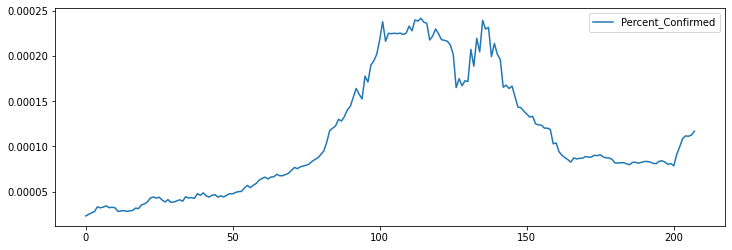

In [13]:
df['Percent_Confirmed'] = df['Confirmed']/state_population[0]
import matplotlib.pyplot as plt
df.plot(y='Percent_Confirmed')

#### Configure options for prediction

The incidence rate pattern will be based on seasonality of similar infectious diseases such as flu. The annual pattern for the seasonal flu has up to three dominant peaks CITATION. Since most of the countries has 1st peak already observed, we use the available historical COVID19 data for the 1st peak and then adjust the 2nd and 3rd peaks by scaling the 1st peak magnitude and duration using Gaussian curves. 

### Important parameters:

##### future_projection_days
- Number of days to project confirmed COVID19 cases in future.

#### country_code, state, state_population, actual_testing_capacity
- Target location specific parameters
- state, state_population parameters to represent the target country when projecting for a country

##### These parameters should be configured based on the target location and current day before running the projections.

*** Additional configurable parameters can be managed in src/config.python

In [14]:
future_projection_days = {'CA':120, 'TX':120}

We extract the estimated population from the census data for the number of individuals 18 and older in 2019.

In [15]:
# state_population = state_data_loader.load_us_population(states)
# for idx in range(len(states)):
#     print('The population of {} for age 18 and older is {}.'.format(states[idx], state_population[idx]))

Testing capacity? Is this needed?

In [16]:
#actual_testing_capacity = 500000
actual_testing_capacity = {'CA':500000, 'TX':500000}

What is country level projection?

In [17]:
country_level_projection = False

In [18]:
#STOP

#### Run simulation-based prediction

We are now ready to run the simulation. It will take several minutes to run for ... days.


Projection for: CA *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
Data Availability Timeline: 2020-04-01 00:00:00 to 2020-10-28 00:00:00
w1_start_dt: 2020-04-11 00:00:00 | w1_peak_dt: 2020-07-20 00:00:00 | w2_start_dt: None | days_between_disease_waves: None
Case Rt: 3606.9390756302496 [0.009128666528406285 %]  |  Init Case Rt: 1492.99285714285 [0.003778559503328501 %]
Case Rate: 1492.99285714285, Incidence Rate: 0.00015114238013314005, Projection Population: 3000, Scaling Factor: 22.054333333333332
Optimization params config: tranmission_control_range: (0.05, 1.0) | wave1_weeks_range: (13, 15) | n_calls: 40
[Real(low=0.05, high=1.0, prior='log-uniform', transform='identity')]

****************************************************************************************************
Learning Iterations # 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,
*************************************************

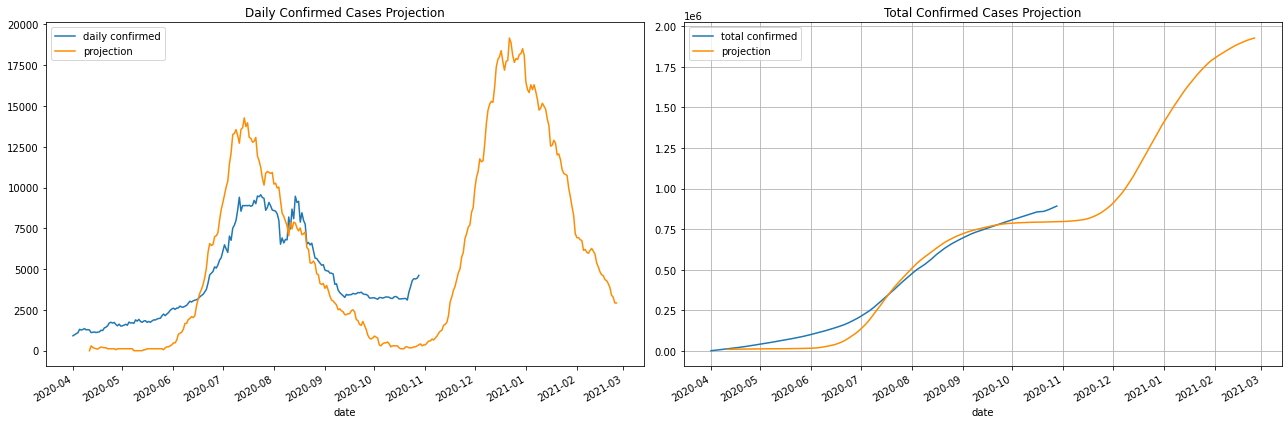



Simulation 2: using 50% end-to-end aggregated interventions:


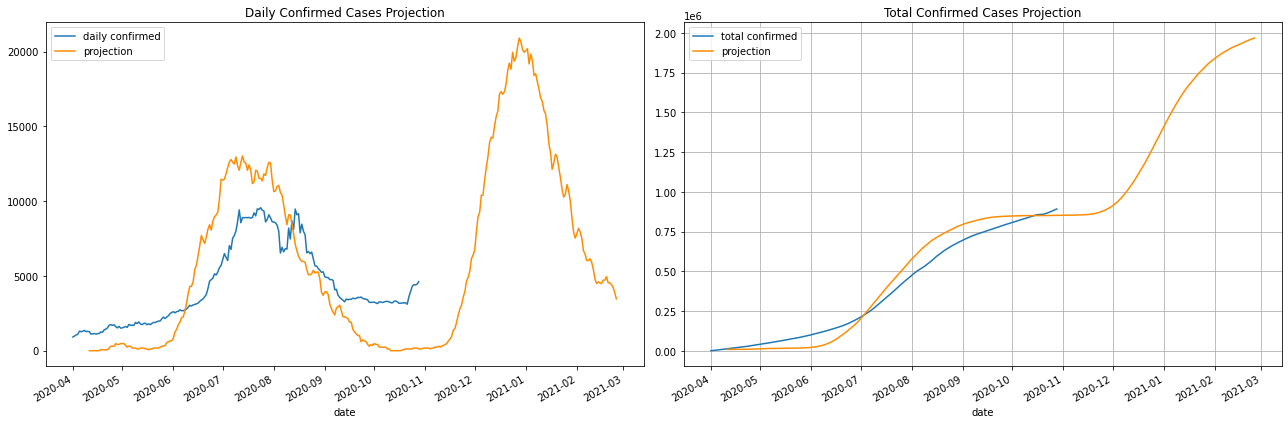



Simulation 3: using 90% end-to-end aggregated interventions:


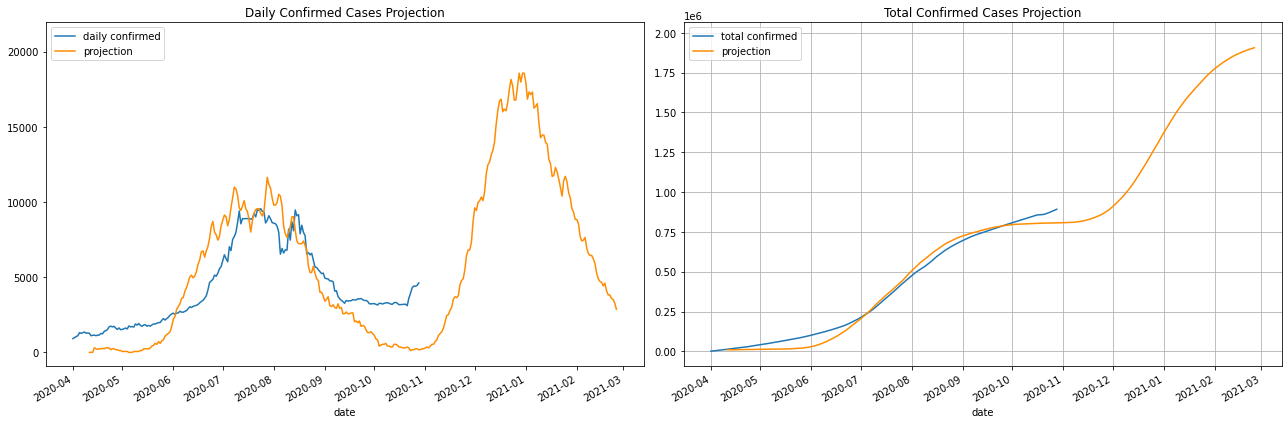

Total Time Taken: 0:11:35.588098

Projection for: TX *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
Data Availability Timeline: 2020-04-01 00:00:00 to 2020-10-28 00:00:00
w1_start_dt: 2020-06-07 00:00:00 | w1_peak_dt: 2020-07-17 00:00:00 | w2_start_dt: None | days_between_disease_waves: None
Case Rt: 5415.653061224484 [0.01867731855164009 %]  |  Init Case Rt: 1799.7357142857188 [0.0062068668107919155 %]
Case Rate: 1799.7357142857188, Incidence Rate: 0.00044334762934227954, Projection Population: 3000, Scaling Factor: 7.518666666666666
Optimization params config: tranmission_control_range: (0.05, 1.0) | wave1_weeks_range: (5, 7) | n_calls: 40
[Real(low=0.05, high=1.0, prior='log-uniform', transform='identity')]

****************************************************************************************************
Learning Iterations # 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,
****************

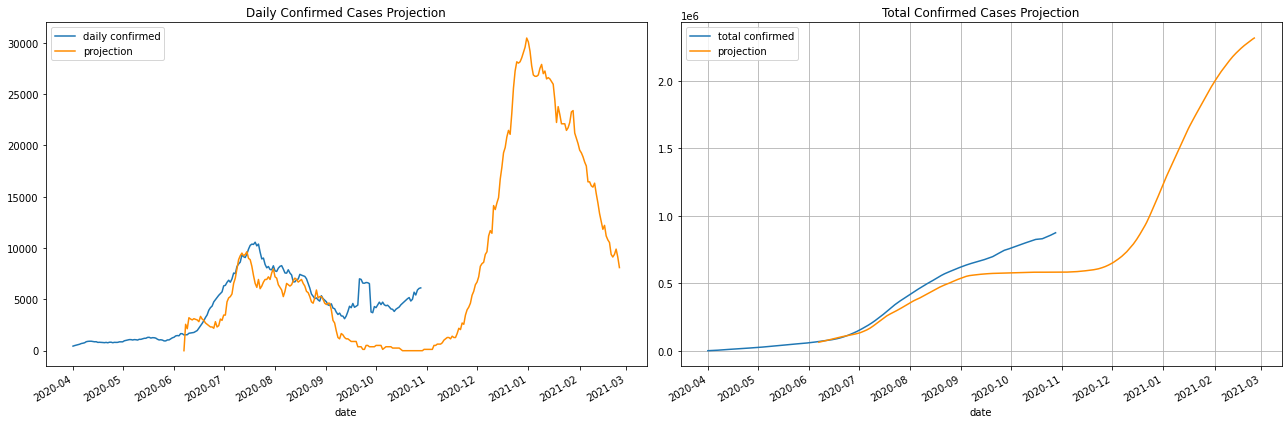



Simulation 2: using 50% end-to-end aggregated interventions:


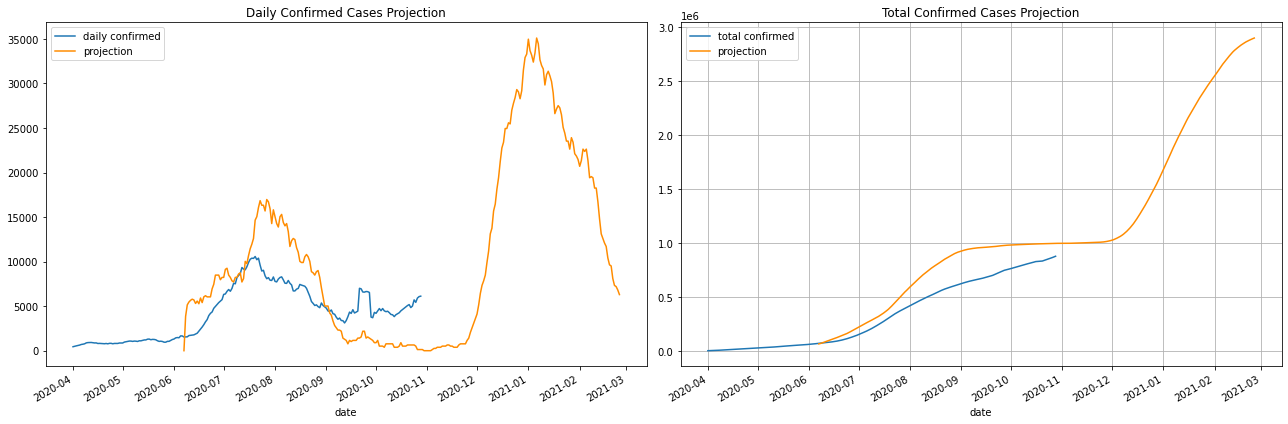



Simulation 3: using 90% end-to-end aggregated interventions:


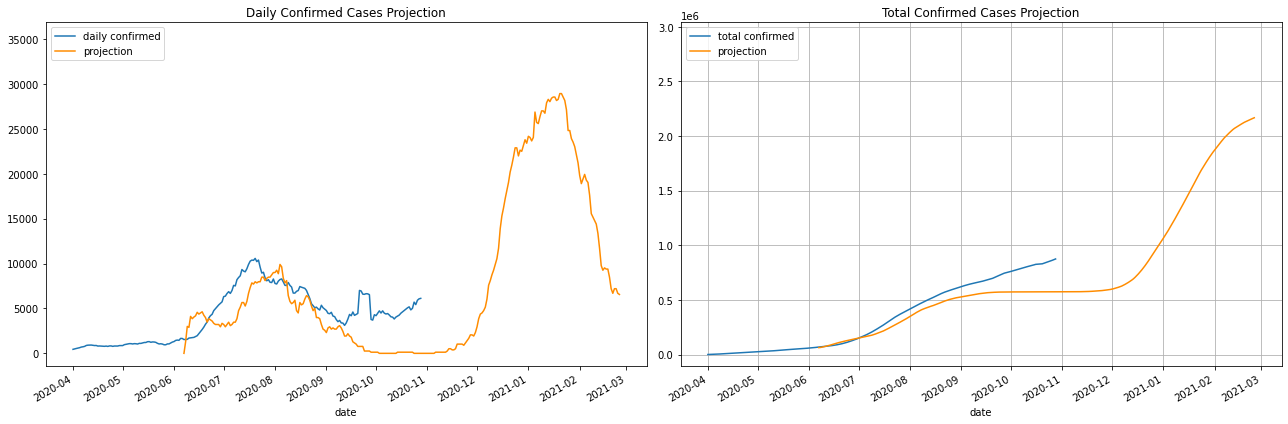

Total Time Taken: 0:04:37.947673


In [19]:
for idx in range(len(states)):
    state = states[idx]
    print ('\nProjection for: {}'.format(state) + ' * ' * 25)
    run (country_code, state, state_population[idx], actual_testing_capacity[state], future_projection_days[state])